In [1]:
import os
import re
import nltk
import mpld3
import joblib
import string
import codecs
# import sklearn.externals
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from itertools import chain
from functools import partial

from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import dendrogram

from gensim import corpora
from gensim import models
from gensim import similarities 

In [2]:
%matplotlib inline

In [3]:
%%html
<style>
table {float:left}
</style>

# Data

## load

In [4]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
links = open('link_list_imdb.txt').read().split('\n')
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
genres = open('genres_list.txt').read().split('\n')
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')

## etl

In [5]:
n = 100

titles = titles[:n]
links = links[:n]
synopses_wiki = synopses_wiki[:n]
genres = genres[:n]
synopses_imdb = synopses_imdb[:n]

In [6]:
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki

In [7]:
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [8]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [9]:
ranks = range(len(titles))

In [10]:
print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


## table

films, 电影

| 字段名| 字段说明 |
| :-- | :-- |
| title | 名称 |
| rank | 排名 |
| synopses | 概要 |
| genres | 流派 |

In [11]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'genre': genres}
df_films = pd.DataFrame(films)

In [12]:
df_films.shape

(100, 4)

In [13]:
df_films.head(1)

,title,rank,synopsis,genre
0,The Godfather,0,Plot [edit] [ [ edit edit ] ] \n On ...,"[u' Crime', u' Drama']"


# Preprocess

## tokenizing

In [14]:
def tokenize(stemmer, text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stemmed = [stemmer.stem(t) for t in filtered_tokens]
    return filtered_tokens, stemmed

In [15]:
nltk.download('punkt')
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package punkt to /home/wangyh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
totalvocab_tokenized, totalvocab_stemmed = zip(*map(partial(tokenize, stemmer), synopses))
totalvocab_tokenized = chain.from_iterable(totalvocab_tokenized)
totalvocab_stemmed = chain.from_iterable(totalvocab_stemmed)

In [17]:
df_tokens = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [18]:
df_tokens.head(1)

,words
plot,Plot


# Embedding

## n-dim

In [19]:
def tokenizer(stemmer, text):
    _, stemmed = tokenize(stemmer, text)
    return stemmed

In [20]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, 
    max_features=200000,
    min_df=0.2, 
    stop_words='english',
    use_idf=True, 
    tokenizer=partial(tokenizer, stemmer), 
    ngram_range=(1,3)
)

In [21]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

/home/wangyh/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 6.8 s, sys: 44 ms, total: 6.84 s
Wall time: 6.84 s


In [22]:
print(tfidf_matrix.shape)

(100, 563)


## n-dim distance

In [23]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [24]:
dist.shape

(100, 100)

## 2-dim

In [25]:
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

In [26]:
# shape = (n_samples, n_components)
pos = mds.fit_transform(dist)
pos.shape

(100, 2)

In [27]:
xs, ys = pos[:, 0], pos[:, 1]

# Clustering

## k-means

In [28]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)

In [29]:
# TODO: may be need normalize/scaling before clustering

In [30]:
%time km.fit(tfidf_matrix)

CPU times: user 340 ms, sys: 16 ms, total: 356 ms
Wall time: 88.7 ms


KMeans(n_clusters=5)

In [31]:
# joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

## linkage ward

## latent dirichlet allocation

In [32]:
# TODO:

#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [33]:
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/wangyh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]
len(preprocess)

100

In [35]:
%time tokenized_text = [tokenize(stemmer, text)[1] for text in preprocess]

CPU times: user 3.31 s, sys: 12 ms, total: 3.32 s
Wall time: 3.32 s


In [36]:
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
print(len(texts[0]))

CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 429 ms
1839


In [37]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [38]:
corpus = [dictionary.doc2bow(text) for text in texts]
len(corpus)

100

In [39]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
print(lda[corpus[0]])

CPU times: user 2min 47s, sys: 3.96 s, total: 2min 51s
Wall time: 42.9 s
[(1, 0.21329267), (2, 0.11066109), (3, 0.6757981)]


In [40]:
topics = lda.print_topics(5, num_words=20)

topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix[:1]

[(0,
  [('shark', 0.005654131),
   ('boat', 0.005175612),
   ('two', 0.0043755914),
   ('water', 0.0043050945),
   ('kill', 0.0037751202),
   ('call', 0.003708089),
   ('come', 0.003295816),
   ('go', 0.0032531412),
   ('away', 0.0032211186),
   ('ask', 0.003171971),
   ('run', 0.0031210796),
   ('car', 0.0030796914),
   ('discov', 0.003067711),
   ('escap', 0.0029762757),
   ('arriv', 0.0029372391),
   ('reveal', 0.0028039322),
   ('day', 0.002743027),
   ('friend', 0.0027396742),
   ('name', 0.002713611),
   ('apart', 0.0026395377)])]

# Report

In [41]:
def pprint(num_clusters, order_centroids, terms, df_tokens, df_films):
    print("Top terms per cluster:")
    print()

    for i in range(num_clusters):

        """ term import -> term vector
        """

        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :6]:
            term = terms[ind]
            term = term.split(' ')
            token = df_tokens.loc[term].values.tolist()[0][0]
            token = token.encode('utf-8', errors='ignore')
            print(token, end=',')

        print()
        print()

        """ cluster id -> title
        """

        print("Cluster %d titles:" % i, end='')

        for title in df_films[df_films['cluster']==i]['title'].values.tolist():
            print(' %s,' % title, end='')

        print()
        print()

In [42]:
def report_pprint(df_films, clusters, tfidf_vectorizer, cluster_centers_, num_clusters, df_tokens):
    
    # add cluster info
    df_films['cluster'] = clusters
    df_films['cluster'].value_counts()
    df_films[['rank', 'cluster']].groupby('cluster').mean()
    
    # top tokens
    terms = tfidf_vectorizer.get_feature_names()
    print(len(terms))
    print(cluster_centers_.shape)
    order_centroids = cluster_centers_.argsort()[:, ::-1]
    
    pprint(num_clusters, order_centroids, terms, df_tokens, df_films)

In [43]:
def visualizing(groups, cluster_names, cluster_colors, df_cluster):
    
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # adds 5% padding to the autoscaling


    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')

        ax.set_aspect('auto')

        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',   # both major and minor ticks are affected
            bottom='off',    # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')

        ax.tick_params(\
            axis= 'y',
            which='both',
            left='off',
            top='off',
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point


    #add label in x,y position with the label as the film title
    for i in range(len(df_cluster)):
        ax.text(df_cluster.iloc[i]['x'], df_cluster.iloc[i]['y'], df_cluster.iloc[i]['title'], size=8)  


    plt.show()
    #plt.savefig('clusters_small_noaxes.png', dpi=200)

In [44]:
def report_visualizing(xs, ys, clusters, titles, cluster_colors, cluster_names):

    df_cluster = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))
    print(df_cluster.shape)
    print(df_cluster.head(1))

    # cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    # cluster_names = {
    #     0: 'Family, home, war', 
    #     1: 'Police, killed, murders', 
    #     2: 'Father, New York, brothers', 
    #     3: 'Dance, singing, love', 
    #     4: 'Killed, soldiers, captain'}

    groups = df_cluster.groupby('label')
    
    visualizing(groups, cluster_names, cluster_colors, df_cluster)

In [45]:
def report(df_films, clusters, tfidf_vectorizer, cluster_centers_, num_clusters, df_tokens, xs, ys, titles, cluster_colors, cluster_names):
    report_pprint(df_films, clusters, tfidf_vectorizer, cluster_centers_, num_clusters, df_tokens)
    report_visualizing(xs, ys, clusters, titles, cluster_colors, cluster_names)

In [46]:
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red', 4: 'purple'}

cluster_names = {
    0: 'Family, home, war', 
    1: 'Police, killed, murders', 
    2: 'Father, New York, brothers', 
    3: 'Dance, singing, love', 
    4: 'Killed, soldiers, captain'}

## k-means

In [47]:
clusters = km.labels_.tolist()
cluster_centers_ = km.cluster_centers_

563
(5, 563)
Top terms per cluster:

Cluster 0 words:b'father',b'children',b'town',b'Robert',b'brothers',b'killed',

Cluster 0 titles: Raging Bull, The Godfather: Part II, The Sound of Music, 12 Angry Men, Amadeus, Unforgiven, To Kill a Mockingbird, Braveheart, High Noon, City Lights, Mr. Smith Goes to Washington, Annie Hall, Terms of Endearment, Wuthering Heights,

Cluster 1 words:b'soldiers',b'killed',b'Army',b'command',b'orders',b'men',

Cluster 1 titles: The Shawshank Redemption, Schindler's List, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Patton, Jaws, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Pianist, The Deer Hunter, All Quiet on the Western Front, The Grapes o

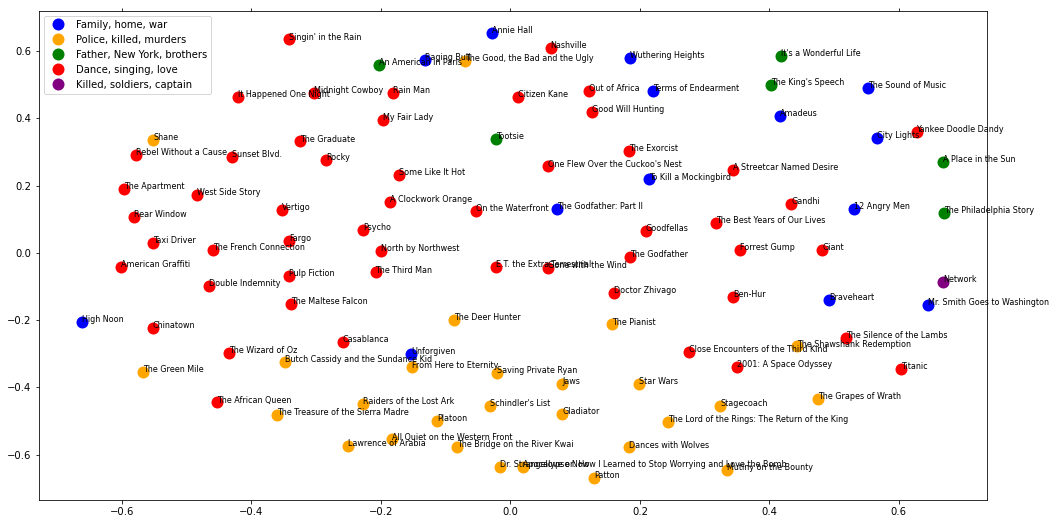

In [48]:
report(df_films, clusters, tfidf_vectorizer, cluster_centers_, num_clusters, df_tokens, xs, ys, titles, cluster_colors, cluster_names)

## latent dirichlet allocation

In [49]:
clusters = list(map(lambda x: sorted(x, key=lambda e: e[1], reverse=True)[0][0], lda[corpus]))

In [50]:
keys = set([e[0] for c in topics_matrix for e in c[1]])
values = [{e[0]:e[1] for e in c[1]} for c in topics_matrix]
cluster_centers_ = np.array([[values[i].get(k,0.) for k in keys] for i in range(len(values))])

563
(5, 59)
Top terms per cluster:

Cluster 0 words:b'actions',b'area',b"'s",b'accompanied',b'bar',b'arrives',

Cluster 0 titles: The Sound of Music, The Silence of the Lambs, Singin' in the Rain, Some Like It Hot, Apocalypse Now, From Here to Eternity, Raiders of the Lost Ark, A Streetcar Named Desire, The Philadelphia Story, Jaws, The Apartment, The French Connection, A Place in the Sun, The Graduate, The African Queen, North by Northwest,

Cluster 1 words:b'bar',b'admit',b'badly',b'attend',b'attention',b'accuses',

Cluster 1 titles: Schindler's List, The Wizard of Oz, Lawrence of Arabia, Forrest Gump, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, Chinatown, The Bridge on the River Kwai, It's a Wonderful Life, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Gandhi, The Lord of the Rings: The Return of the King, Saving Private Ryan, Ben-Hur, Patton, Braveheart, Platoon, Dances with Wolves, The Pianist, The Deer Hunter, All Quiet on the Western Front, Mr. Smi

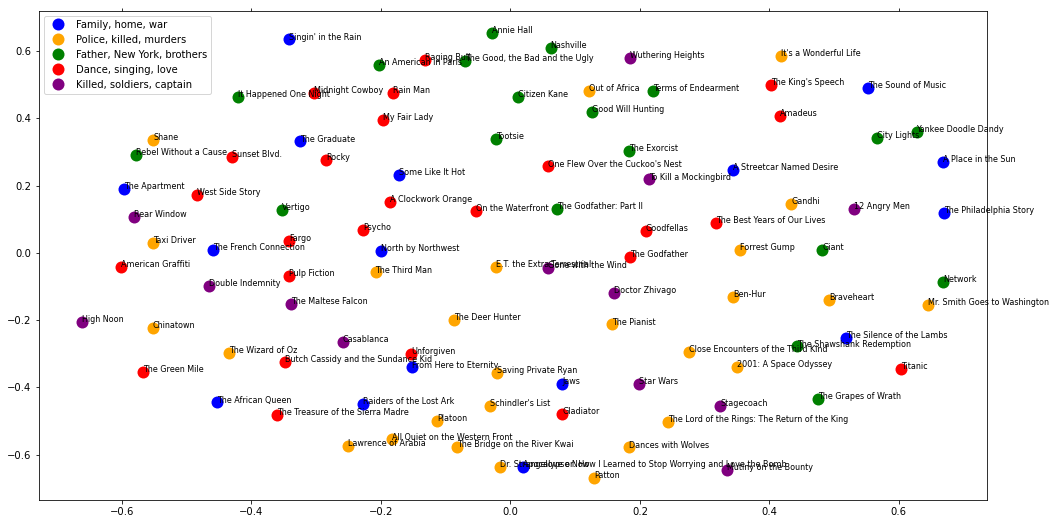

In [51]:
report(df_films, clusters, tfidf_vectorizer, cluster_centers_, num_clusters, df_tokens, xs, ys, titles, cluster_colors, cluster_names)

## visualizing hierarchical